In [1]:
%pip install -r req.txt

Note: you may need to restart the kernel to use updated packages.


# Creating Neural Network
- Input Size: 1 x (2 x m), where m = number of regression models
- 4 models: Linear, Poly, XGBoost, Rand Forest, GPR

# Imports 

In [2]:
# core libraries
import pandas as pd 
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# preprocessing
from sklearn.model_selection import train_test_split

# metrics 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F

# Data Preprocessing

In [3]:
file = "datasets/sim_data_800.csv"
df = pd.read_csv(file)

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check data types
print("Data types:\n", df.dtypes)

Missing values:
 pred_1        0
conf_1        0
pred_2        0
conf_2        0
pred_3        0
conf_3        0
pred_4        0
conf_4        0
true_angle    0
dtype: int64
Data types:
 pred_1        float64
conf_1        float64
pred_2        float64
conf_2        float64
pred_3        float64
conf_3        float64
pred_4        float64
conf_4        float64
true_angle    float64
dtype: object


# Visualize dataset
---
- visualizes sample of first 100 predictions and true angles

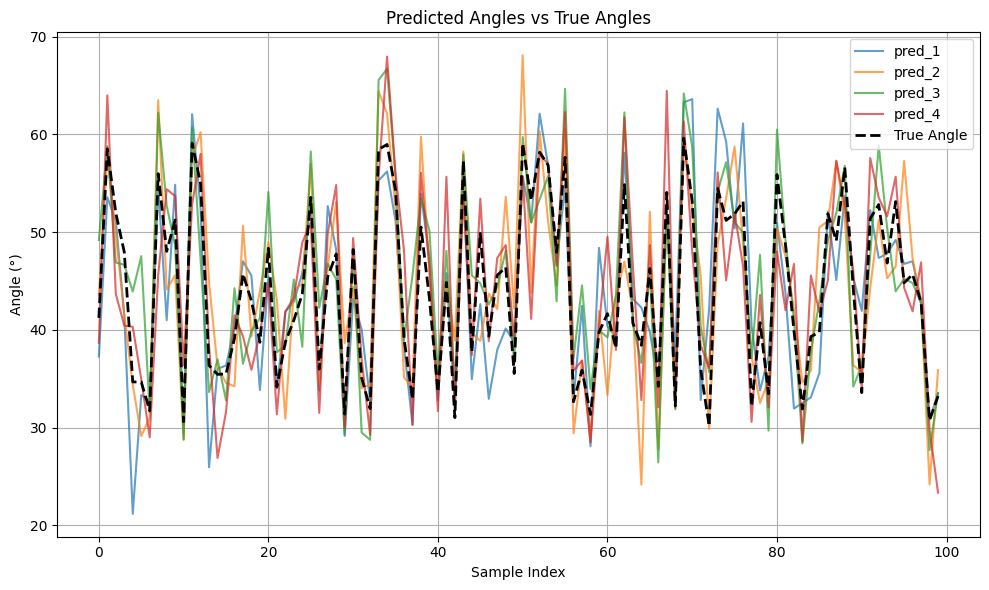

In [4]:
sample_df = df.iloc[:100]  # first 100 rows
plt.figure(figsize=(10, 6))

# Plot each prediction column
for col in sample_df.columns:
    if col.startswith("pred"):
        plt.plot(sample_df.index, sample_df[col], label=col, alpha=0.7)

# Plot the true angles
plt.plot(sample_df.index, sample_df["true_angle"], label="True Angle", color="black", linewidth=2, linestyle='--')

plt.xlabel("Sample Index")
plt.ylabel("Angle (°)")
plt.title("Predicted Angles vs True Angles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Data Prep
---

### Masking predictions with confidence > threshold

In [5]:
threshold = 1.0
pred_cols = ['pred_1', 'pred_2', 'pred_3', 'pred_4']
conf_cols = ['conf_1', 'conf_2', 'conf_3', 'conf_4']

# build X = original predictions + confidence values
X = df[pred_cols + conf_cols].values.astype(np.float32)

# creating copy of original df
adjusted_preds = df[pred_cols].copy()

# mask predictions with low confidence with NaN
for i in range(4):
    mask = df[conf_cols[i]] > threshold
    adjusted_preds.loc[mask, pred_cols[i]] = np.nan

In [6]:
errors = np.abs(adjusted_preds.values - df['true_angle'].values[:, None])
errors[np.isnan(errors)] = 1e6  # large penalty for invalid predictions
y = np.argmin(errors, axis=1)  # class labels: 0, 1, 2, 3

In [7]:
# 70/15/15 split as NumPy Arrays
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Convert train/val/test NumPy Arrays into Tensors

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# wrap into a dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# create training batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [9]:
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# wrap into a dataset
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create val batches
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# wrap into a dataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create test batches
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Model Architecture
- 2 hidden layer MLP

In [11]:
class ModelSelector(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ModelSelector, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size), # first hidden layer
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), # second hidden layer
            nn.ReLU(),
            nn.Linear(hidden_size, output_size), # output layer
        )

    def forward(self, x):
        return self.net(x)
    

In [12]:
model = ModelSelector(input_size=8, hidden_size=32, output_size=4)

# Training

In [13]:
#check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)
model.to(device)

Using device: cuda


ModelSelector(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [14]:
# initalize optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [15]:
num_epochs = 50
best_val_loss = float('inf')
patience_limit = 10
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        # move data to GPU or CPU
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # forward step
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # backward step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate running loss
        running_loss += loss.item() * X_batch.size(0)

    # total training loss
    train_loss = running_loss / len(train_loader.dataset)


    # validation phase
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            # move data to GPU or CPU
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)

            # forward step
            val_outputs = model(X_val_batch)
            loss = criterion(val_outputs, y_val_batch)

            # calculate running loss 
            val_loss += loss.item() * X_val_batch.size(0)

    val_loss /= len(val_loader.dataset)


    # adding early stopping to prevent overfitting            
    if val_loss < best_val_loss:
        best_val_loss = val_loss 
        best_model_state = model.state_dict()
        print(f"Saving best model... at epoch {epoch+1}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print(f"Early stopping at epoch {epoch+1}")
            break

        
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Patience: {patience_counter}")

Saving best model... at epoch 1
Epoch 1/50 | Train Loss: 1.3040 | Val Loss: 1.1494 | Patience: 0
Saving best model... at epoch 2
Epoch 2/50 | Train Loss: 1.2261 | Val Loss: 1.1363 | Patience: 0
Epoch 3/50 | Train Loss: 1.2172 | Val Loss: 1.1671 | Patience: 1
Saving best model... at epoch 4
Epoch 4/50 | Train Loss: 1.2053 | Val Loss: 1.1219 | Patience: 0
Epoch 5/50 | Train Loss: 1.1987 | Val Loss: 1.1323 | Patience: 1
Epoch 6/50 | Train Loss: 1.2018 | Val Loss: 1.1477 | Patience: 2
Saving best model... at epoch 7
Epoch 7/50 | Train Loss: 1.1744 | Val Loss: 1.0990 | Patience: 0
Saving best model... at epoch 8
Epoch 8/50 | Train Loss: 1.1744 | Val Loss: 1.0839 | Patience: 0
Saving best model... at epoch 9
Epoch 9/50 | Train Loss: 1.1588 | Val Loss: 1.0829 | Patience: 0
Saving best model... at epoch 10
Epoch 10/50 | Train Loss: 1.1540 | Val Loss: 1.0785 | Patience: 0
Epoch 11/50 | Train Loss: 1.1413 | Val Loss: 1.0963 | Patience: 1
Saving best model... at epoch 12
Epoch 12/50 | Train Loss:

In [16]:
# load best model after training
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Testing 

In [17]:
model.eval()
y_preds = []
y_trues = []
running_loss = 0.0

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_batch = X_test_batch.to(device)
        y_batch = y_test_batch.to(device)

        outputs = model(X_batch)  # raw logits
        loss = criterion(outputs, y_batch)

        # Apply softmax + argmax
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        # Store predictions and true labels
        y_preds.extend(preds.cpu().numpy())
        y_trues.extend(y_batch.cpu().numpy())

        running_loss += loss.item() * X_batch.size(0)

test_loss = running_loss / len(test_loader.dataset)
print(f"\nTest Loss: {test_loss:.4f}")

# Classification metrics
print(f"\nTest Accuracy: {accuracy_score(y_trues, y_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_trues, y_preds, target_names=["Model 1", "Model 2", "Model 3", "Model 4"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_trues, y_preds))


Test Loss: 0.7685

Test Accuracy: 0.6750

Classification Report:
              precision    recall  f1-score   support

     Model 1       0.70      0.94      0.80        64
     Model 2       0.60      0.80      0.69        15
     Model 3       0.64      0.41      0.50        17
     Model 4       0.67      0.08      0.15        24

    accuracy                           0.68       120
   macro avg       0.65      0.56      0.53       120
weighted avg       0.67      0.68      0.61       120


Confusion Matrix:
[[60  1  3  0]
 [ 1 12  1  1]
 [ 9  1  7  0]
 [16  6  0  2]]
